In [1]:
import practicalSPARQL
import pandas as pd
import ast
import matplotlib.pyplot as plt

In [2]:
root_q = 'queries'
root_d = 'results'

# read login data
login = pd.read_json('config_sparql.json')
ENDPOINT = login['endpoint'][0]
USERNAME = login['username'][0]
PASSWORD = login['password'][0]

# create sparql object
sparql = practicalSPARQL.practicalWrapper(ENDPOINT)
sparql.setCredentials(USERNAME, PASSWORD)

print("--- Querying ENDPOINT: {} ---".format(ENDPOINT))

--- Querying ENDPOINT: http://devmeta.sphaera.mpiwg-berlin.mpg.de/sparql ---


In [3]:
q = practicalSPARQL.stringify_SPARQL('elements_query_050824.sparql')    # select data from the ttl file as a dataframe
df = sparql.select_as_dataframe(q)

In [4]:
q = practicalSPARQL.stringify_SPARQL('books_query.sparql')    # select data from the ttl file as a dataframe
books = sparql.select_as_dataframe(q)

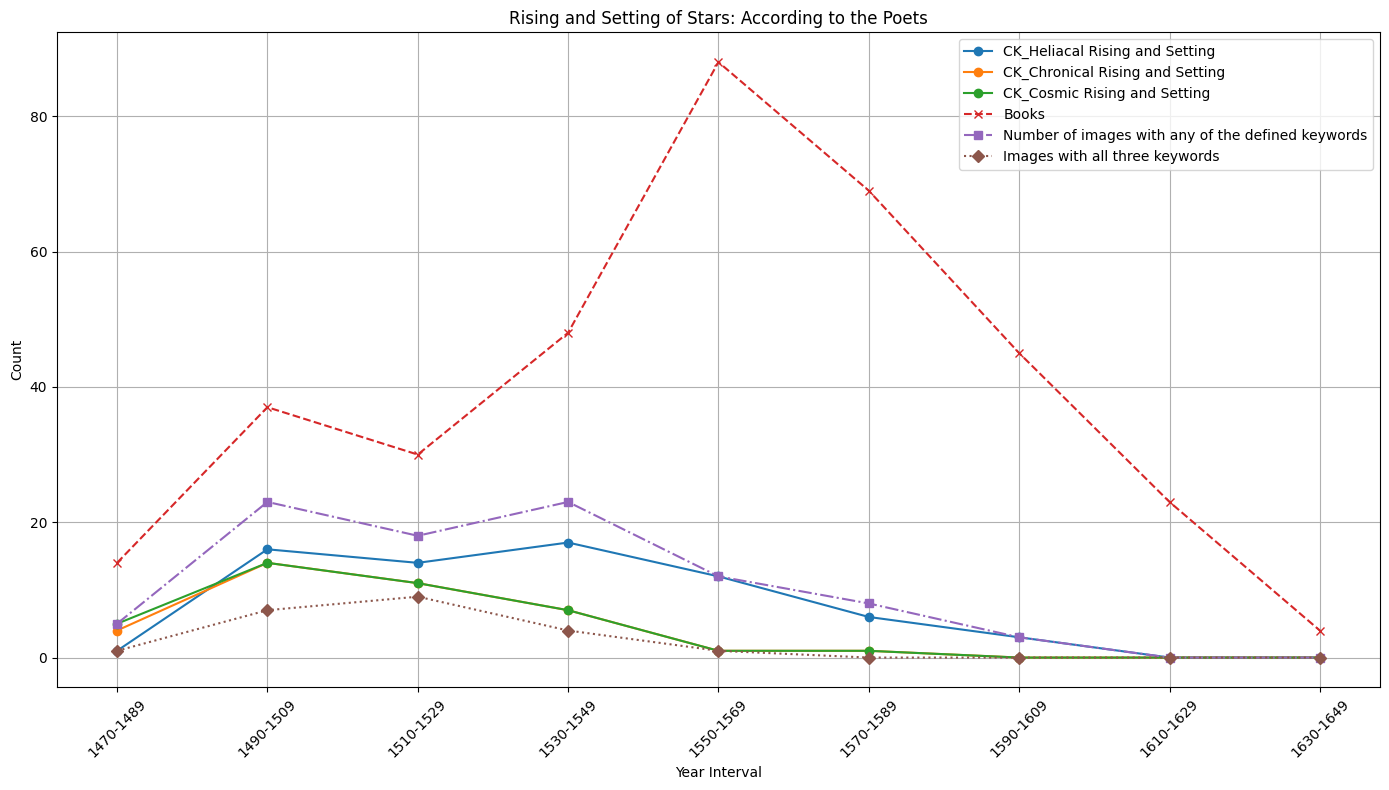

In [10]:
# Ensure the year column is of integer type
df['year'] = df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649'
]

# Add interval column to the DataFrames
df['interval'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define keywords
keywords = [
    'CK_Heliacal Rising and Setting', 'CK_Chronical Rising and Setting', 'CK_Cosmic Rising and Setting'
]

# Prepare a DataFrame for each keyword
keyword_dfs = {}
for keyword in keywords:
    mask = df['cks'].apply(lambda x: keyword in x)
    filtered_df = df[mask]
    unique_images_per_interval = filtered_df.groupby('interval', observed=False)['images'].nunique().reset_index()  # Added observed=False
    unique_images_per_interval.columns = ['interval', f'unique_images_{keyword}']
    keyword_dfs[keyword] = unique_images_per_interval

# Merge all keyword DataFrames on 'interval'
merged_keyword_df = pd.merge(keyword_dfs[keywords[0]], keyword_dfs[keywords[1]], on='interval', how='outer')
for keyword in keywords[2:]:
    merged_keyword_df = pd.merge(merged_keyword_df, keyword_dfs[keyword], on='interval', how='outer')

# Count unique books per interval
unique_books_per_interval = books.groupby('interval', observed=False)['book'].nunique().reset_index()  # Added observed=False
unique_books_per_interval.columns = ['interval', 'unique_books']

# Merge the keyword DataFrame with the books DataFrame
final_df = pd.merge(merged_keyword_df, unique_books_per_interval, on='interval', how='outer')

# Count the unique images that have any of the keywords (union of the masks)
# Create a mask for each keyword
masks = [df['cks'].apply(lambda x: keyword in x) for keyword in keywords]
# Combine masks using logical OR (to get images that have any of the keywords)
combined_mask = masks[0]
for mask in masks[1:]:
    combined_mask |= mask

# Filter for images that match any of the keywords
filtered_df_combined = df[combined_mask]
unique_images_combined_per_interval = filtered_df_combined.groupby('interval', observed=False)['images'].nunique().reset_index()  # Added observed=False
unique_images_combined_per_interval.columns = ['interval', 'total_unique_images']

# Merge this data with the final DataFrame
final_df = pd.merge(final_df, unique_images_combined_per_interval, on='interval', how='outer')

# Calculate the unique images that contain all three keywords
mask_all_keywords = df['cks'].apply(lambda x: all(keyword in x for keyword in keywords))
filtered_df_all_keywords = df[mask_all_keywords]
unique_images_all_keywords_per_interval = filtered_df_all_keywords.groupby('interval', observed=False)['images'].nunique().reset_index()  # Added observed=False
unique_images_all_keywords_per_interval.columns = ['interval', 'unique_images_all_keywords']

# Merge this data with the final DataFrame
final_df = pd.merge(final_df, unique_images_all_keywords_per_interval, on='interval', how='outer')

# Plot the results
plt.figure(figsize=(14, 8))

# Plot each keyword
for keyword in keywords:
    plt.plot(final_df['interval'], final_df[f'unique_images_{keyword}'], label=f'{keyword}', marker='o')

# Plot unique books
plt.plot(final_df['interval'], final_df['unique_books'], label='Books', marker='x', linestyle='--')

# Plot total unique images (any of the keywords)
plt.plot(final_df['interval'], final_df['total_unique_images'], label='Number of images with any of the defined keywords', marker='s', linestyle='-.')

# Plot images with all three keywords
plt.plot(final_df['interval'], final_df['unique_images_all_keywords'], label='Images with all three keywords', marker='D', linestyle=':')

plt.xlabel('Year Interval')
plt.ylabel('Count')
plt.title('Rising and Setting of Stars: According to the Poets')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
# Define keywords
#keywords = [
#    'CK_Heliacal Rising and Setting', 
#    'CK_Chronical Rising and Setting', 
#    'CK_Cosmic Rising and Setting'
#]

# Define a function to check if any keyword is in a string
#def contains_keywords(cks_value):
#    return any(keyword in cks_value for keyword in keywords)

# Create a boolean mask for the keywords
#mask = df['cks'].apply(contains_keywords)

# Filter the DataFrame based on the mask
#filtered_df = df[mask]

# Get the unique cluster_name values
#unique_cluster_names = filtered_df['cluster_name'].unique().tolist()

# Convert the list to a DataFrame
#unique_cluster_names_df = pd.DataFrame(unique_cluster_names, columns=['cluster_name'])

# Save the DataFrame to an Excel file
#output_file = 'rising_setting_poets.xlsx'
#unique_cluster_names_df.to_excel(output_file, index=False)


In [27]:
# Define the values to filter by
keywords = ['CK_Heliacal Rising and Setting', 'CK_Chronical Rising and Setting', 'CK_Cosmic Rising and Setting']

# Create a boolean mask for filtering
mask = df['cks'].apply(lambda x: any(keyword in x for keyword in keywords))

# Filter the DataFrame
filtered_df = df[mask]

# Path to the Excel file
excel_file_path = 'C:\\Users\\nogas\\Image_data\\rising_setting_poets.xlsx'

# Load the Excel file into a DataFrame
excel_data = pd.read_excel(excel_file_path)

rising_setting_poets_visual = pd.merge(filtered_df, excel_data, on='cluster_name', how='left')

rising_setting_poets_visual

,images,cluster_name,cks,book,bid,part_or_adaption,part_or_adaption_label,type_label,custom_identifier,place,year,flag,interval,face or figure,double image,3D decoration,3D,color,human figure,writing within the image
0,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_00501,"CK_Heliacal Rising and Setting, CK_Chronical R...",http://sphaera.mpiwg-berlin.mpg.de/id/item/91f...,1925,http://sphaera.mpiwg-berlin.mpg.de/id/adaption...,Anonymous commentary (foeliciter inchoat),"Annotated, Content",322,Venice,1490,nan,1490-1509,yes,no,no,no,no,no,yes
1,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,SAC_SIL_00501,"CK_Heliacal Rising and Setting, CK_Chronical R...",http://sphaera.mpiwg-berlin.mpg.de/id/item/0be...,1924,http://sphaera.mpiwg-berlin.mpg.de/id/adaption...,Anonymous commentary (foeliciter inchoat),"Content, Annotated",322,Venice,1488,nan,1470-1489,yes,no,no,no,no,no,yes
2,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_00501,"CK_Heliacal Rising and Setting, CK_Chronical R...",http://sphaera.mpiwg-berlin.mpg.de/id/item/b49...,1926,http://sphaera.mpiwg-berlin.mpg.de/id/adaption...,Anonymous commentary (foeliciter inchoat),"Annotated, Content",322,Venice,1491,nan,1490-1509,yes,no,no,no,no,no,yes
3,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_00501,"CK_Heliacal Rising and Setting, CK_Chronical R...",http://sphaera.mpiwg-berlin.mpg.de/id/item/b8e...,1622,http://sphaera.mpiwg-berlin.mpg.de/id/adaption...,Tractatus de sphaera,"Annotated, Content",329,Venice,1494,nan,1490-1509,yes,no,no,no,no,no,yes
4,http://db.sphaera.mpiwg-berlin.mpg.de/containe...,SAC_SIL_00497,CK_Heliacal Rising and Setting,http://sphaera.mpiwg-berlin.mpg.de/id/item/0ad...,2091,http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...,Tractatus de sphaera,"Original Part, Content",100,Wittenberg,1531,nan,1530-1549,yes,no,no,no,yes,no,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,SAC_SIL_00497,CK_Heliacal Rising and Setting,http://sphaera.mpiwg-berlin.mpg.de/id/item/ebf...,1682,http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...,Tractatus de sphaera,"Original Part, Content",100,Venice,1541,nan,1530-1549,yes,no,no,no,yes,no,yes
88,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,SAC_SIL_00497,CK_Heliacal Rising and Setting,http://sphaera.mpiwg-berlin.mpg.de/id/item/278...,2112,http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...,Tractatus de sphaera,"Original Part, Content",100,Venice,1553,nan,1550-1569,yes,no,no,no,yes,no,yes
89,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,SAC_SIL_01401,CK_Heliacal Rising and Setting,http://sphaera.mpiwg-berlin.mpg.de/id/item/28e...,2232,http://sphaera.mpiwg-berlin.mpg.de/id/part/22a...,Witekind's treatise on the Sphere,"Original Part, Content",520,Neustadt an der Weinstraße,1590,nan,1590-1609,no,no,no,yes,no,no,yes
90,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,SAC_SIL_00497,CK_Heliacal Rising and Setting,http://sphaera.mpiwg-berlin.mpg.de/id/item/6d6...,1752,http://sphaera.mpiwg-berlin.mpg.de/id/part/c61...,Tractatus de sphaera,"Content, Original Part",100,Venice,1601,nan,1590-1609,yes,no,no,no,yes,no,yes


C:\Users\nogas\AppData\Local\Temp\ipykernel_3700\3133211019.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)
C:\Users\nogas\AppData\Local\Temp\ipykernel_3700\3133211019.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)
C:\Users\nogas\AppData\Local\Temp\ipykernel_3700\3133211019.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to reta

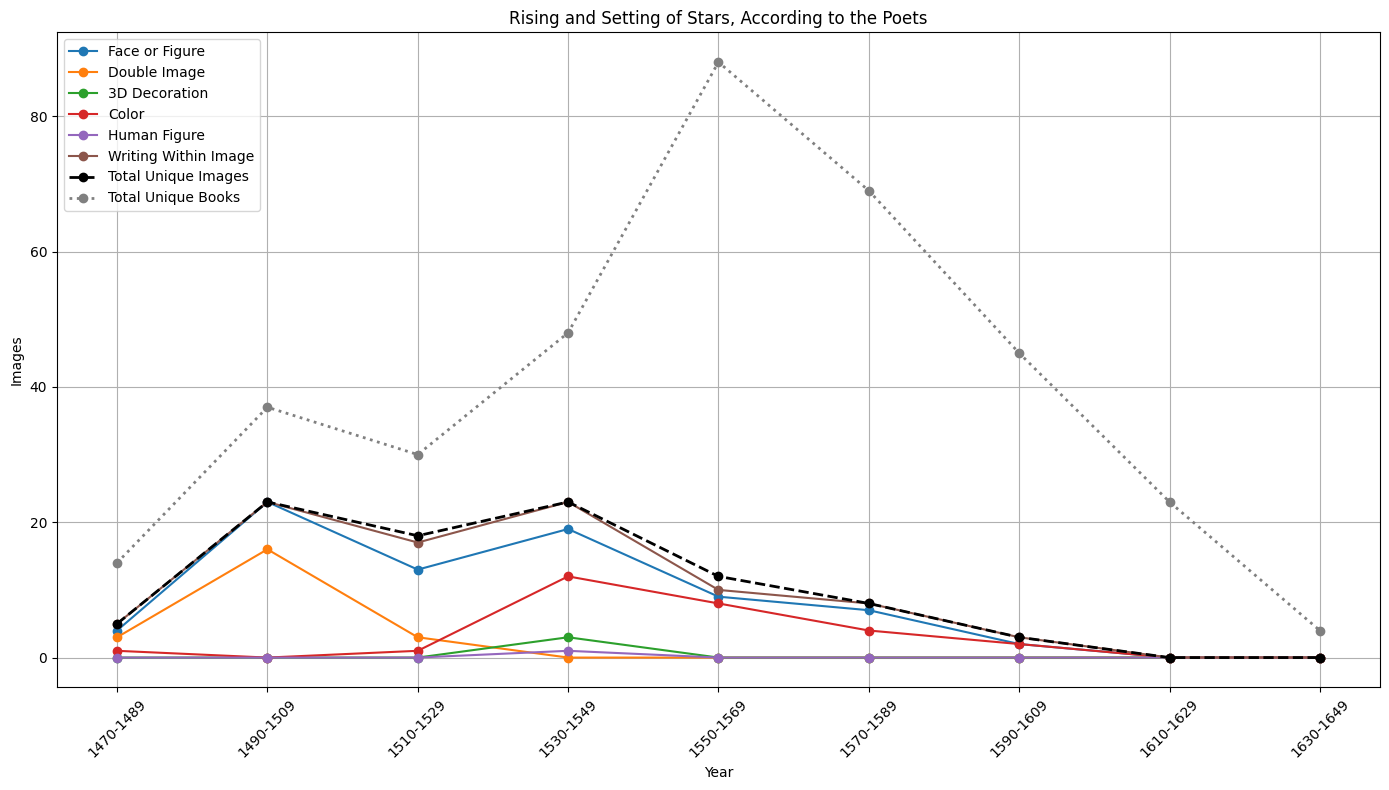

In [28]:
# Convert 'year' to int
rising_setting_poets_visual['year'] = rising_setting_poets_visual['year'].astype(int)
books['year'] = books['year'].astype(int)

# Create 20-year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = ['1470-1489', '1490-1509', '1510-1529', '1530-1549', '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649']

# Create a new column for the 20-year intervals
rising_setting_poets_visual['interval'] = pd.cut(rising_setting_poets_visual['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Function to count unique images by column
def count_unique_images_by_column(column_name, value):
    filtered_df = rising_setting_poets_visual[rising_setting_poets_visual[column_name] == value]
    return filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Collect data with updated column names
face_or_figure = count_unique_images_by_column('face or figure', 'yes')
double_image = count_unique_images_by_column('double image', 'yes')
three_dimensions_effect = count_unique_images_by_column('3D decoration', 'yes')
color = count_unique_images_by_column('color', 'yes')
human_figures = count_unique_images_by_column('human figure', 'yes')
writing_within_image = count_unique_images_by_column('writing within the image', 'yes')

# Combine the data for lines
side_by_side_data = pd.DataFrame({
    'Face or Figure': face_or_figure,
    'Double Image': double_image,
    '3D Decoration': three_dimensions_effect,
    'Color': color,
    'Human Figure': human_figures,
    'Writing Within Image': writing_within_image
})

# Calculate total unique books and images for each interval
total_unique_books_df = books.groupby('interval')['book'].nunique().reindex(labels, fill_value=0)
total_unique_images = filtered_df.groupby('interval')['images'].nunique().reindex(labels, fill_value=0)

# Plot lines with single y-axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot lines for each category on primary y-axis
for column in side_by_side_data.columns:
    ax.plot(labels, side_by_side_data[column], marker='o', linestyle='-', label=column)

# Plot lines for total unique images and total unique books
ax.plot(labels, total_unique_images, marker='o', linestyle='--', color='black', label='Total Unique Images', linewidth=2)
ax.plot(labels, total_unique_books_df, marker='o', linestyle=':', color='gray', label='Total Unique Books', linewidth=2)

# Formatting the plot
ax.set_xlabel('Year')
ax.set_ylabel('Images')
ax.set_title('Rising and Setting of Stars, According to the Poets')
ax.legend(loc='upper left')
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\nogas\AppData\Local\Temp\ipykernel_3700\2653386067.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
C:\Users\nogas\AppData\Local\Temp\ipykernel_3700\2653386067.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
C:\Users\nogas\AppData\Local\Temp\ipykernel_3700\2653386067.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

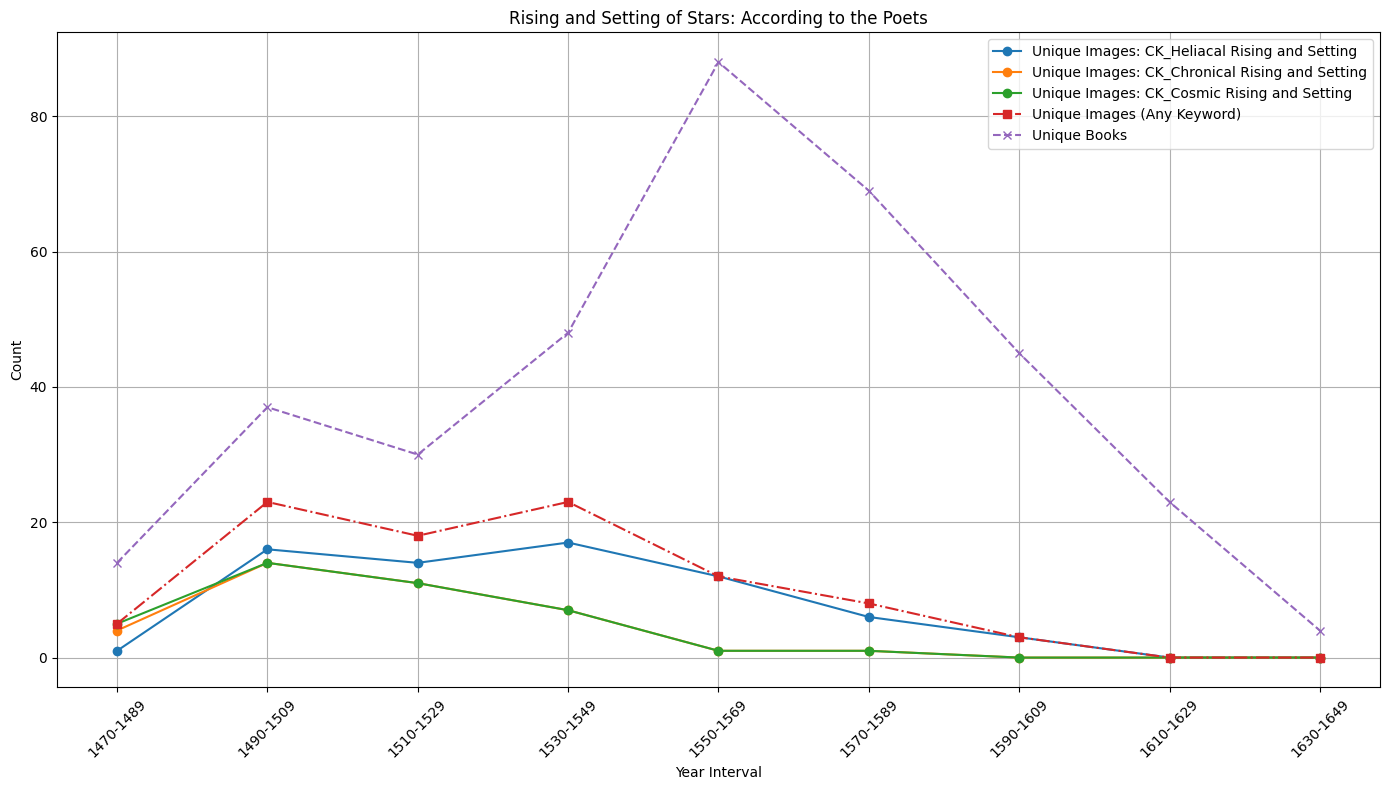

In [29]:
# Ensure the year column is of integer type
df['year'] = df['year'].astype(int)
books['year'] = books['year'].astype(int)

# Define bins and labels for year intervals
bins = [1470, 1490, 1510, 1530, 1550, 1570, 1590, 1610, 1630, 1650]
labels = [
    '1470-1489', '1490-1509', '1510-1529', '1530-1549',
    '1550-1569', '1570-1589', '1590-1609', '1610-1629', '1630-1649'
]

# Add interval column to the DataFrames
df['interval'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
books['interval'] = pd.cut(books['year'], bins=bins, labels=labels, right=False)

# Define keywords
keywords = [
    'CK_Heliacal Rising and Setting', 'CK_Chronical Rising and Setting', 'CK_Cosmic Rising and Setting'
]

# Prepare a DataFrame to hold unique counts for each keyword
keyword_dfs = {}
for keyword in keywords:
    mask = df['cks'].apply(lambda x: keyword in x)
    filtered_df = df[mask]
    unique_images_per_interval = filtered_df.groupby('interval')['images'].nunique().reset_index()
    unique_images_per_interval.columns = ['interval', f'unique_images_{keyword}']
    keyword_dfs[keyword] = unique_images_per_interval

# Create a single mask for all keywords for the combined count
combined_mask = df['cks'].apply(lambda x: any(keyword in x for keyword in keywords))
filtered_combined_df = df[combined_mask]
unique_images_combined = filtered_combined_df.groupby('interval')['images'].nunique().reset_index()
unique_images_combined.columns = ['interval', 'unique_images_any']

# Merge all keyword DataFrames on 'interval'
merged_keyword_df = keyword_dfs[keywords[0]]
for keyword in keywords[1:]:
    merged_keyword_df = pd.merge(merged_keyword_df, keyword_dfs[keyword], on='interval', how='outer')

# Merge the combined unique images DataFrame
final_df = pd.merge(merged_keyword_df, unique_images_combined, on='interval', how='outer')

# Count unique books per interval
unique_books_per_interval = books.groupby('interval')['book'].nunique().reset_index()
unique_books_per_interval.columns = ['interval', 'unique_books']
final_df = pd.merge(final_df, unique_books_per_interval, on='interval', how='outer')

# Plot the results
plt.figure(figsize=(14, 8))

# Plot each keyword's unique images
for keyword in keywords:
    plt.plot(final_df['interval'], final_df[f'unique_images_{keyword}'], label=f'Unique Images: {keyword}', marker='o')

# Plot total unique images with any of the keywords
plt.plot(final_df['interval'], final_df['unique_images_any'], label='Unique Images (Any Keyword)', marker='s', linestyle='-.')

# Plot unique books
plt.plot(final_df['interval'], final_df['unique_books'], label='Unique Books', marker='x', linestyle='--')

plt.xlabel('Year Interval')
plt.ylabel('Count')
plt.title('Rising and Setting of Stars: According to the Poets')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
